# Second Full Classification Attempt

General Pipeline:

Classify 4s subsegments --> threshold --> classify full recording

- Preprocessing = BPF (0.5-50Hz), Keep all electrodes separate
- Feature Extraction = canonical 5-band power, ISPC?, NEO? Entropy?
- Simple supervised classification of 4s subsegments (SVM)
- %subsegments=preictal --> Threshold hyperparameter --> classify preictal vs interictal

Abandoning MNE bc it's slower, some weird performance decrease, and ICA did not reveal any artifacts

In [1]:
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import (periodogram as periodogram,
                         butter as butter,
                         lfilter as lfilter)
from timeit import default_timer as timer
from sklearn.decomposition import PCA as PCA
from sklearn.svm import SVC as SVC
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.metrics import precision_recall_fscore_support as prf
from copy import copy as copy
from tqdm.notebook import tqdm
import mne
from scipy.signal import decimate

In [2]:
class SubSegment:
    def __init__(self, data, data_length_sec, fs, channels, sequence):
        self.data = data
        self.data_length_sec = data_length_sec
        self.fs = fs
        self.channels = channels
        self.sequence = sequence
        self.t = np.linspace(0, self.data_length_sec, self.data.shape[0])
    
    def get_psd(self, data, f_low=0.5, f_high=50):
        self.freq, self.psd, self.band_psd = [], [], []
        band_lims = (0, 4, 8, 12, 30, 100)
        freq, psd = periodogram(data, self.fs)
        psd = 10*np.log10(psd)
        self.psd = psd[np.logical_and(freq>=0.5, freq<=50)]
        self.freq = freq[np.logical_and(freq>=0.5, freq<=50)]
        for l_lim, u_lim in zip(band_lims[:-1], band_lims[1:]):
            band_mask = np.logical_and(freq>l_lim, freq<=u_lim)
            band_power = np.sum(psd[band_mask]) / np.sum(band_mask)
            self.band_psd.append(band_power)
            
    def plot_raw_data(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.data)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw_zoomed(self, start_idx, end_idx):
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_psd(self):
        fig, ax = plt.subplots()
        ax.plot(self.freq, self.psd)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Spectral Power (dB)")
        return fig, ax
    
    def plot_band_psd(self):
        x = np.arange(5)
        bands = ["delta (0-4Hz)", "theta (4-8Hz)", "alpha (8-12Hz)", "beta (12-30Hz)", "gamma (30-50Hz)"]
        fig, ax = plt.subplots()
        ax.scatter(x, self.band_psd)
        ax.set_xticks(x)
        ax.set_xticklabels(bands)
        ax.set_ylabel("Spectral Power Density (dB/Hz)")
        return fig, ax
    
    def plot_all(self, start_idx, end_idx):
        self.plot_raw_data()
        self.plot_raw_zoomed(start_idx, end_idx)
        self.plot_psd()
        self.plot_band_psd()

In [3]:
class Segment(SubSegment):
    def __init__(self, path, var):
        self.load_struct(path, var)
        self.filter_seg(fs=self.fs)
        #self.get_psd(self.data)
        self.split_seg(4)
        
    def load_struct(self, path, var):
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self.data_length_sec = seg_struct[1][0][0]
        self.fs = seg_struct[2][0][0]
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord=1, cutoff_low=0.5, cutoff_high=50, fs=1):
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        mean_raw = np.mean(self.raw_data, axis=1)
        self.data = lfilter(b, a, mean_raw)
    
    def split_seg(self, t_split):
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.fs
        self.subsegments = []
        for i in range(num_seg):
            seg_data = self.data[i*seg_len:(i+1)*seg_len]
            seg = SubSegment(seg_data, t_split, self.fs, ['mean'], self.sequence)
            seg.get_psd(seg_data)
            self.subsegments.append(seg)
            

In [4]:
interictal_1 = Segment("Patient_1_interictal_segment_0001.mat", 'interictal_segment_1')
preictal_1 = Segment("Patient_1_preictal_segment_0001.mat", "preictal_segment_1")

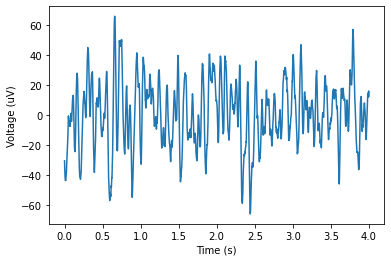

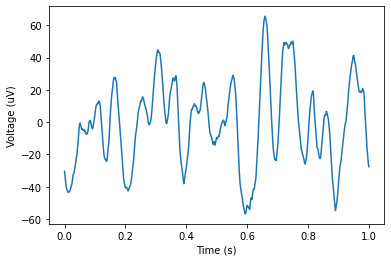

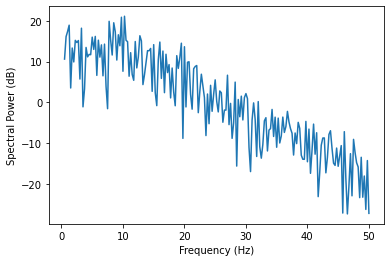

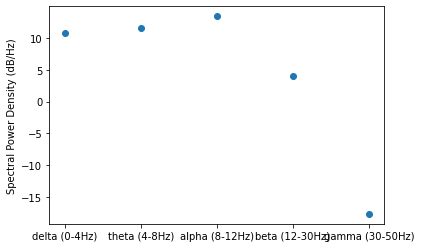

In [5]:
interictal_1.subsegments[123].plot_all(0, interictal_1.fs)

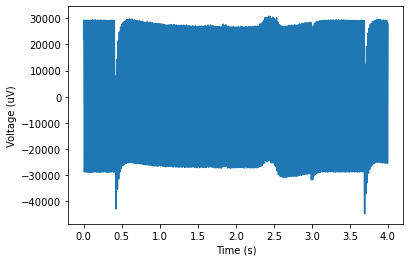

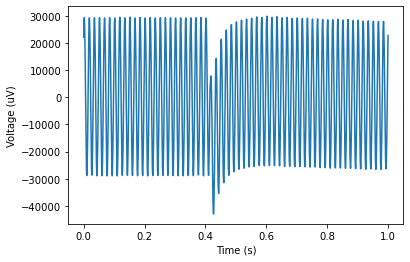

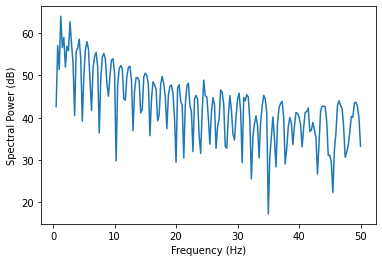

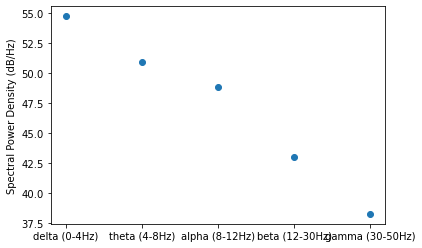

In [6]:
preictal_1.subsegments[123].plot_all(0, interictal_1.fs)

Preprocessing and PSD of raw data

In [6]:
def listsubfolders(root):
    contents = os.listdir(root)
    subfolders = []
    for item in os.listdir(root):
        item_path = os.path.join(root, item)
        if not(os.path.isfile(item_path)):
            subfolders.append(item)
    return subfolders

In [8]:
i_band, p_band, i_seg_names, p_seg_names = [], [], [], []
root = "seizure-prediction"
for folder in listsubfolders(root):
    if folder != "Patient_1":
        continue
    print(folder)
    datapath = os.path.join(os.path.join(root, folder), folder)
    for i, matfile in enumerate(os.listdir(datapath)):
        if i%50==0:
            print("{}/{}".format(i, len(os.listdir(datapath))))
        seg_path = os.path.join(datapath, matfile)
        if "test" in matfile:
            continue
        elif "interictal" in matfile:
            seg_name = "interictal_segment_"+str(int(matfile[-8:-4]))
            interictal_seg = Segment(seg_path, seg_name)
            for subseg in interictal_seg.subsegments:
                i_band.append(subseg.band_psd)
            i_seg_names.append(seg_name)
        else: #preictal
            seg_name = "preictal_segment_"+str(int(matfile[-8:-4]))
            preictal_seg = Segment(seg_path, seg_name)
            for subseg in preictal_seg.subsegments:
                p_band.append(subseg.band_psd)
            p_seg_names.append(seg_name)

Patient_1
0/263


<ipython-input-2-227c13932155>:14: RuntimeWarning: divide by zero encountered in log10
  psd = 10*np.log10(psd)


50/263
100/263
150/263
200/263
250/263


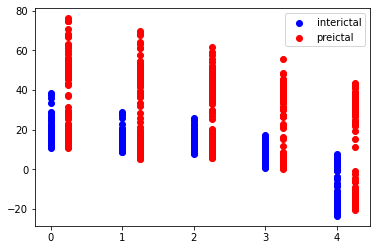

In [9]:
x = np.arange(5)
plt.figure()
plt.hold = True
for i, sample_band in enumerate(i_band):
    if i%100 != 0: #only plot every one in 100
        continue
    if i == 0:
        plt.scatter(x, sample_band, c="b", label="interictal")
    else:
        plt.scatter(x, sample_band, c="b")
for i, sample_band in enumerate(p_band):
    if i%10 != 0:
        continue
    if i == 0:
        plt.scatter(x+0.25, sample_band, c="r", label="preictal")
    else:
        plt.scatter(x+0.25, sample_band, c="r")
plt.legend()

PCA to visualize and cluster

In [10]:
pca = PCA()
ip_band = i_band + p_band
pca_band = pca.fit_transform(ip_band)
num_i = len(i_band)

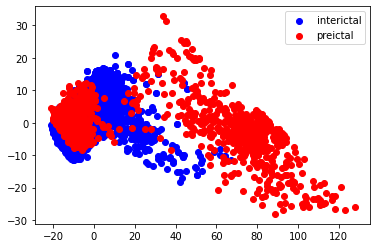

In [11]:
plt.figure()
plt.scatter(pca_band[:num_i, 0], pca_band[:num_i, 1], c="b", label="interictal")
plt.scatter(pca_band[num_i:, 0], pca_band[num_i:, 1], c="r", label="preictal")
plt.legend()

SVM to classify data

In [15]:
labels = [0]*num_i + [1]*(len(ip_band)-num_i)
X_train, X_test, y_train, y_test = train_test_split(pca_band, labels, test_size=0.33)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [16]:
svc = SVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
pred_train = svc.predict(X_train)
train_acc = svc.score(X_train, y_train)
test_acc = svc.score(X_test, y_test)

Train Accuracy:0.8882060286801288%%
Test Accuracy:0.887106357694593%%
precision: [0.88609023 0.89093484], recall: [0.96836483 0.6748927 ], f_score: [0.92540243 0.76800977]


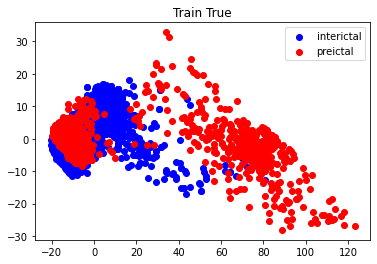

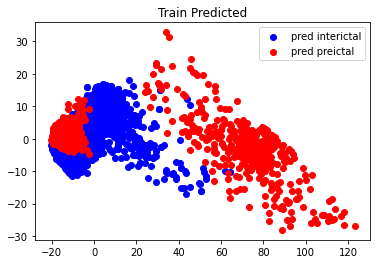

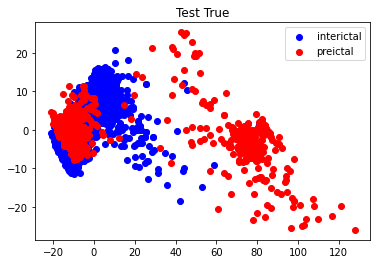

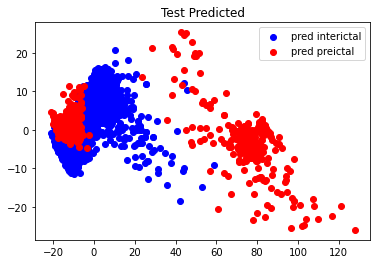

In [17]:
plt.figure()
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="b", label="interictal")
plt.scatter(X_train[y_train ==1, 0], X_train[y_train==1, 1], c="r", label="preictal")
plt.legend()
plt.title("Train True")

plt.figure()
plt.scatter(X_train[pred_train==0, 0], X_train[pred_train==0, 1], c="b", label="pred interictal")
plt.scatter(X_train[pred_train==1, 0], X_train[pred_train==1, 1], c="r", label="pred preictal")
plt.legend()
plt.title("Train Predicted")
print("Train Accuracy:{}%%".format(train_acc))

plt.figure()
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="b", label="interictal")
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="r", label="preictal")
plt.legend()
plt.title("Test True")

plt.figure()
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1], c="b", label="pred interictal")
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], c="r", label="pred preictal")
plt.legend()
plt.title("Test Predicted")
print("Test Accuracy:{}%%".format(test_acc))

precision, recall, f_score, _ = prf(y_test, pred)
print("precision: {}, recall: {}, f_score: {}".format(precision, recall, f_score))

## LOO Cross-Validation on patient 1

In [8]:
def load_patients(pat_names):
    i_bands, p_bands = [], []
    for folder in listsubfolders(root):
        if not(folder in pat_names):
            continue
        print(folder)
        datapath = os.path.join(os.path.join(root, folder), folder)
        matfiles = [file for file in os.listdir(datapath) if not("test" in file)]
        for matfile in tqdm(matfiles):
            seg_path = os.path.join(datapath, matfile)
            if "interictal" in matfile:
                seg_name = "interictal_segment_"+str(int(matfile[-8:-4]))
                interictal_seg = Segment(seg_path, seg_name)
                seg_band = []
                for subseg in interictal_seg.subsegments:
                    seg_band.append(subseg.band_psd)
                i_bands.append(seg_band)
            else: #preictal
                seg_name = "preictal_segment_"+str(int(matfile[-8:-4]))
                preictal_seg = Segment(seg_path, seg_name)
                seg_band = []
                for subseg in preictal_seg.subsegments:
                    seg_band.append(subseg.band_psd)
                p_bands.append(seg_band)
    return i_bands, p_bands
#i_bands, p_bands = load_patients(["Patient_1"])

In [9]:
def plot_pred(X_train, y_train, pred_train, X_test, y_test, pred_test):
    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
    ax[0, 0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c="b", label="interictal")
    ax[0, 0].scatter(X_train[y_train ==1, 0], X_train[y_train==1, 1], c="r", label="preictal")
    fig.legend()
    ax[0, 0].set_title("Train True")

    ax[0, 1].scatter(X_train[pred_train==0, 0], X_train[pred_train==0, 1], c="b", label="pred interictal")
    ax[0, 1].scatter(X_train[pred_train==1, 0], X_train[pred_train==1, 1], c="r", label="pred preictal")
    ax[0, 1].set_title("Train Predicted")
    train_acc = svc.score(X_train, y_train)
    print("Train Accuracy:{}".format(train_acc))

    ax[1, 0].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c="b", label="interictal")
    ax[1, 0].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c="r", label="preictal")
    ax[1, 0].set_title("Test True")

    ax[1, 1].scatter(X_test[pred_test==0, 0], X_test[pred_test==0, 1], c="b", label="pred interictal")
    ax[1, 1].scatter(X_test[pred_test==1, 0], X_test[pred_test==1, 1], c="r", label="pred preictal")
    ax[1, 1].set_title("Test Predicted")
    test_acc = svc.score(X_test, y_test)
    print("Test Accuracy:{}".format(test_acc))

    precision, recall, f_score, _ = prf(y_test, pred_test)
    print("precision: {}, recall: {}, f_score: {}".format(precision, recall, f_score))

In [11]:
def loo_xval(i_bands, p_bands):
    loo_accs, i_seg_pred, p_seg_pred = [], [], []
    preictal_thresh = 0.25
    for i in tqdm(range(len(i_bands))):
        p_loo_seg_list = p_bands[i%len(p_bands)]
        p_band = copy(p_bands)
        p_band.pop(i%len(p_bands))
        p_band = sum(p_band, [])

        i_loo_seg_list = i_bands[i]
        i_band = copy(i_bands)
        i_band.pop(i)
        i_band = sum(i_band, [])

        #PCA
        pca = PCA()
        ip_band = i_band + p_band
        pca_band = pca.fit_transform(ip_band)
        num_i = len(i_band)
        labels = [0]*num_i + [1]*(len(ip_band)-num_i)

        #SVM
        svc = SVC()
        svc.fit(pca_band, labels)
        pred_train = svc.predict(pca_band)
        zero = np.array(0)
        one = np.array(1)

        #LOO Eval
        loo_ip_band = i_loo_seg_list + p_loo_seg_list
        loo_labels = [0]*len(i_loo_seg_list) + [1]*len(p_loo_seg_list)
        loo_pca_bands = pca.transform(loo_ip_band)
        loo_pred = svc.predict(loo_pca_bands)
        loo_accs.append(svc.score(loo_pca_bands, loo_labels))
        if np.sum(loo_pred[:len(i_loo_seg_list)]) / len(i_loo_seg_list) > preictal_thresh:
            i_seg_pred.append(1)
        else:
            i_seg_pred.append(0)
        if i < len(p_bands):
            if np.sum(loo_pred[len(i_loo_seg_list):]) / len(p_loo_seg_list) > preictal_thresh:
                p_seg_pred.append(1)
            else:
                p_seg_pred.append(0)
    return loo_accs, i_seg_pred, p_seg_pred 
#loo_accs, i_seg_pred, p_seg_pred = loo_xval(i_bands, p_bands)

In [12]:
def print_performance(loo_accs, i_seg_pred, p_seg_pred):
    loo_accs = np.array(loo_accs)
    cross_val_acc = np.mean(loo_accs)
    cross_val_std = np.std(loo_accs)
    print("LOO Cross-Validated Subsegment Accuracy: {} +/- {}".format(cross_val_acc, cross_val_std))
    pred_test = i_seg_pred + p_seg_pred
    y_test = [0]*len(i_seg_pred) + [1]*len(p_seg_pred)
    precision, recall, f_score, _ = prf(y_test, pred_test)
    acc = sum(np.array(pred_test) == np.array(y_test)) / len(y_test)
    print("LOO Cross-Validated Segment accuracy: {}, precision: {}, recall: {}, f_score: {}".format(
        acc, precision, recall, f_score))
#print_performance(loo_accs, i_seg_pred, p_seg_pred)

Add Time-Space-Frequency Information: Morlet Wavelet, IPSC, etc.

In [7]:
class SubSegment:
    def __init__(self, data, data_length_sec, fs, channels, sequence):
        self.data = data
        self.data_length_sec = data_length_sec
        self.fs = fs
        self.channels = channels
        self.sequence = sequence
        self.t = np.linspace(0, self.data_length_sec, self.data.shape[0])
    
    def get_psd(self, data, f_low=0.5, f_high=50):
        data = np.mean(data, axis=1)
        self.freq, self.psd, self.band_psd = [], [], []
        band_lims = (0, 4, 8, 12, 30, 100)
        freq, psd = periodogram(data, self.fs)
        psd = 10*np.log10(psd)
        self.psd = psd[np.logical_and(freq>=0.5, freq<=50)]
        self.freq = freq[np.logical_and(freq>=0.5, freq<=50)]
        for l_lim, u_lim in zip(band_lims[:-1], band_lims[1:]):
            band_mask = np.logical_and(freq>l_lim, freq<=u_lim)
            band_power = np.sum(psd[band_mask]) / np.sum(band_mask)
            self.band_psd.append(band_power)
        self.band_psd = np.array(self.band_psd)
    
    def get_tfr(self, data):
        self.band_centers = [2, 6, 10, 20, 40]
        data = np.swapaxes(np.expand_dims(data, axis=0), 1, 2)
        tfr = mne.time_frequency.tfr_array_morlet(data, freqs=self.band_centers, sfreq=int(self.fs), n_cycles=2,
                                                  output='complex')
        self.tfr = tfr[0]
        
    def get_ispc(self):
        num_ch = len(self.channels)
        num_bands = len(self.band_centers)
        phase = np.angle(self.tfr)
        ispc = np.zeros(num_bands)
        num_pairs = 0
        for i in range(num_ch):
            for j in range(i+1, num_ch):
                phase_diff = phase[i, :, :] - phase[j, :, :]
                ispc += np.abs(np.mean(np.exp(1j*phase_diff), axis=1))
                num_pairs += 1
        self.ispc = ispc / num_pairs
    def minmax_norm(self, x):
        max_x = np.max(np.abs(x))
        minmax = np.array([max_x])
        norm_x = x / max_x
        return norm_x, minmax
        
    def get_feats(self, data, f_low=0.5, f_high=50):
        #skip normalization entirely to improve performance
        self.get_psd(data, f_low, f_high)
        self.get_tfr(data)
        self.get_ispc()
        self.feats = np.concatenate((self.band_psd, self.ispc), axis=0)
            
    def plot_raw_data(self):
        fig, ax = plt.subplots()
        ax.plot(self.t, self.data)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw_zoomed(self, start_idx, end_idx):
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_psd(self):
        fig, ax = plt.subplots()
        ax.plot(self.freq, self.psd)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Spectral Power (dB)")
        return fig, ax
    
    def plot_band_psd(self):
        x = np.arange(5)
        bands = ["delta (0-4Hz)", "theta (4-8Hz)", "alpha (8-12Hz)", "beta (12-30Hz)", "gamma (30-50Hz)"]
        fig, ax = plt.subplots()
        ax.scatter(x, self.band_psd)
        ax.set_xticks(x)
        ax.set_xticklabels(bands)
        ax.set_ylabel("Spectral Power Density (dB/Hz)")
        return fig, ax
    
    def plot_tfr(self, channels):
        n_down = 20 #downsampling factor for plotting
        down_t = self.t[:len(self.t):n_down]
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = decimate(self.tfr[i], n_down)
            down_amp = np.abs(down_tfr)
            down_phase = np.angle(down_tfr)
            fig, axs = plt.subplots(2, 1)
            pcm_amp = axs[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto')
            cbar_amp = fig.colorbar(pcm_amp, ax=axs[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = axs[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto')
            cbar_phase = fig.colorbar(pcm_phase, ax=axs[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
    
    def plot_all(self, start_idx, end_idx):
        self.plot_raw_data()
        self.plot_raw_zoomed(start_idx, end_idx)
        self.plot_psd()
        self.plot_band_psd()
        self.plot_tfr(self.channels)

In [8]:
class Segment(SubSegment):
    def __init__(self, path, var):
        self.load_struct(path, var)
        self.filter_seg(fs=self.fs)
        self.split_seg(4)
        
    def load_struct(self, path, var):
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self.data_length_sec = seg_struct[1][0][0]
        self.fs = seg_struct[2][0][0]
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord=1, cutoff_low=0.5, cutoff_high=50, fs=1):
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        self.data = lfilter(b, a, self.raw_data)
    
    def split_seg(self, t_split):
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.fs
        self.subsegments = []
        prog_bar = tqdm(range(num_seg), leave=False)
        for i in prog_bar:
            seg_data = self.data[i*seg_len:(i+1)*seg_len]
            seg = SubSegment(seg_data, t_split, self.fs, self.channels, self.sequence)
            seg.get_feats(seg_data)
            self.subsegments.append(seg)
        prog_bar.close()
            

In [9]:
interictal_1 = Segment("Patient_1_interictal_segment_0001.mat", 'interictal_segment_1')

  0%|          | 0/150 [00:00<?, ?it/s]

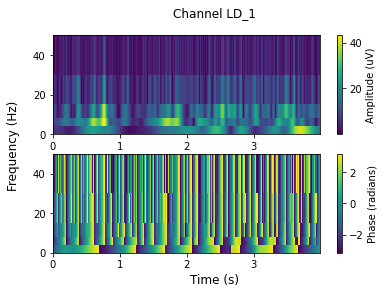

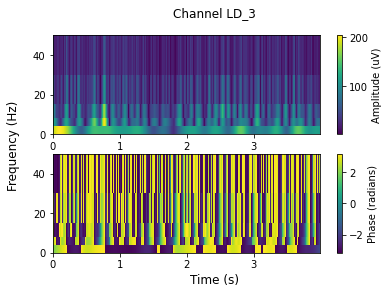

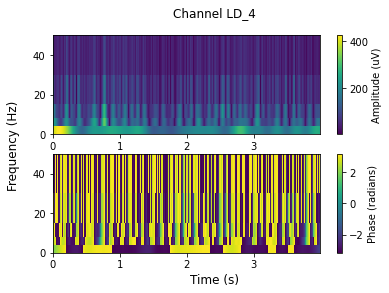

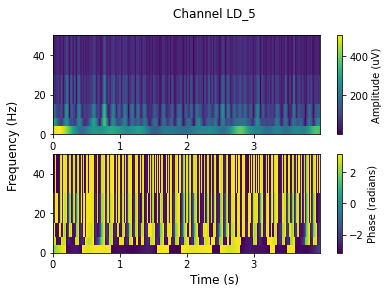

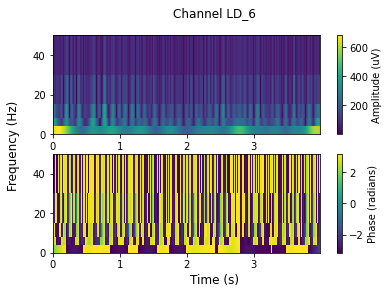

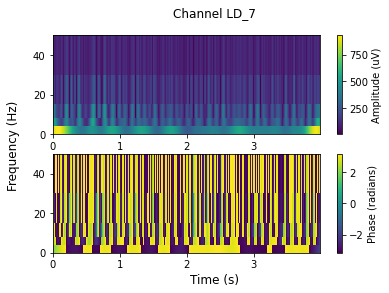

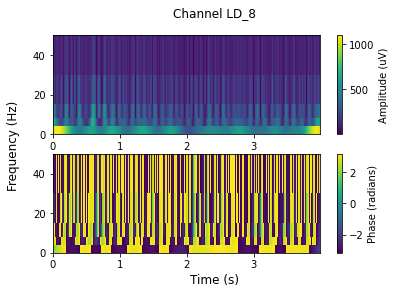

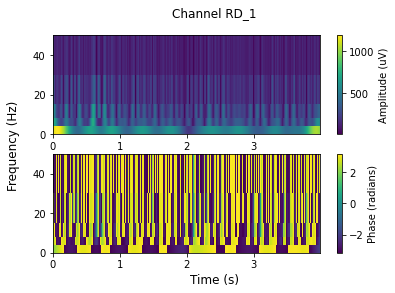

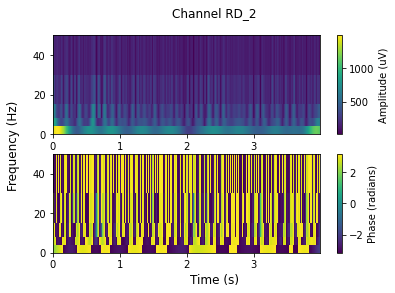

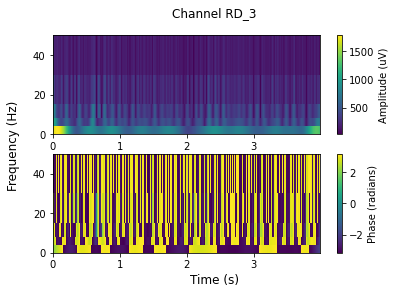

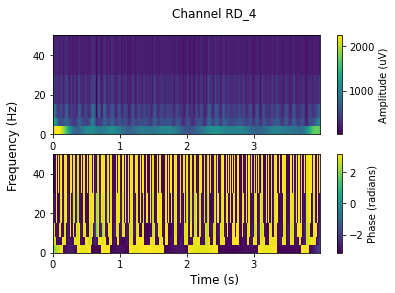

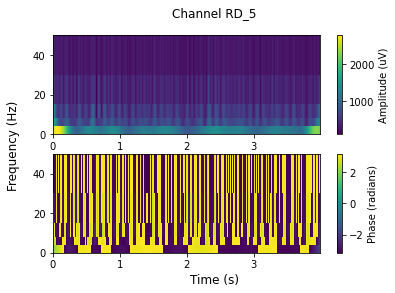

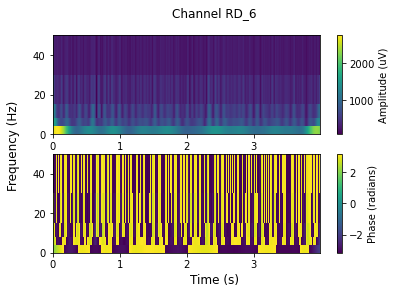

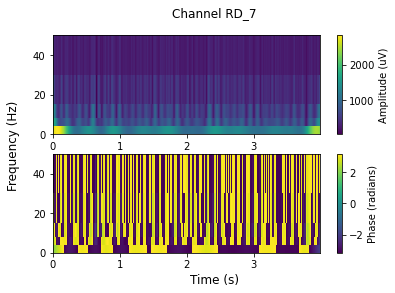

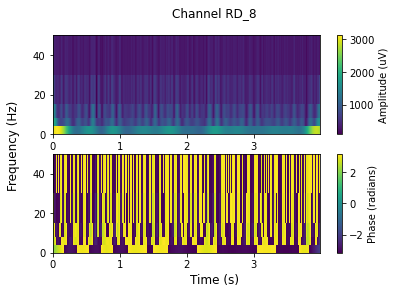

In [36]:
interictal_1.subsegments[123].plot_tfr(interictal_1.channels)

(0.0, 1.0)

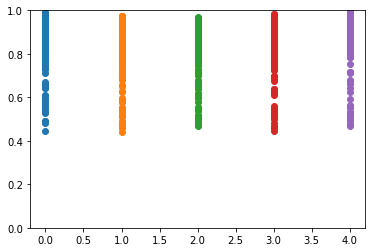

In [61]:
ispcs = []
for seg in interictal_1.subsegments:
    ispcs.append(seg.ispc)
ispcs = np.array(ispcs)
plt.figure()
for i in range(5):
    plt.scatter(np.ones(150)*i, ispcs[:, i])
plt.ylim([0, 1])

IndexError: index 6 is out of bounds for axis 1 with size 6

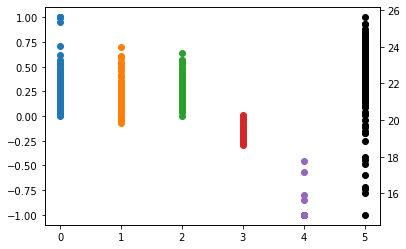

In [135]:
feats = []
for seg in interictal_1.subsegments:
    feats.append(seg.feats)
feats = np.array(feats)
fig, ax = plt.subplots()
for i in range(12):
    if i == 5:
        ax2 = ax.twinx()
        ax2.scatter(np.ones(150)*i, feats[:, i], color='k')
    else:
        ax.scatter(np.ones(150)*i, feats[:, i])
#plt.ylim([0, 1])

Need to do some kind of normalization to use band Power (dB) and ISPC (fraction 0-1) together: minmax norm with additional variable to record the abs max value for each subsegment. 


In [88]:
preictal_1 = Segment("Patient_1_preictal_segment_0001.mat", "preictal_segment_1")

  0%|          | 0/150 [00:00<?, ?it/s]

(0.0, 1.0)

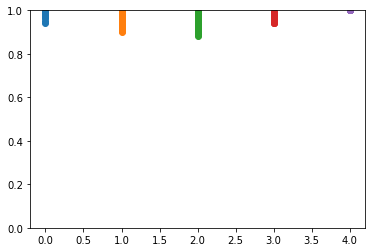

In [89]:
ispcs = []
for seg in preictal_1.subsegments:
    ispcs.append(seg.ispc)
ispcs = np.array(ispcs)
plt.figure()
for i in range(5):
    plt.scatter(np.ones(150)*i, ispcs[:, i])
plt.ylim([0, 1])

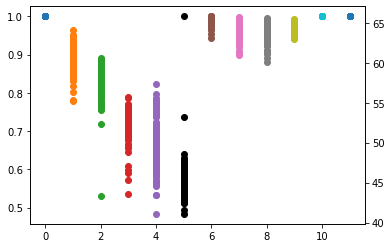

In [90]:
feats = []
for seg in preictal_1.subsegments:
    feats.append(seg.feats)
feats = np.array(feats)
fig, ax = plt.subplots()
for i in range(12):
    if i == 5:
        ax2 = ax.twinx()
        ax2.scatter(np.ones(150)*i, feats[:, i], color='k')
    else:
        ax.scatter(np.ones(150)*i, feats[:, i])

## Sample Segments from Patient 2

  0%|          | 0/150 [00:00<?, ?it/s]

(0.0, 1.0)

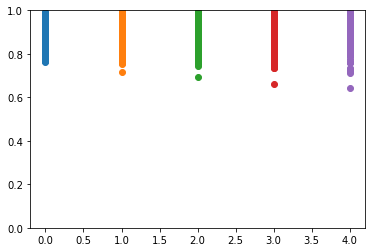

In [26]:
preictal_1 = Segment("Patient_2_preictal_segment_0001.mat", "preictal_segment_1")
ispcs = []
for seg in preictal_1.subsegments:
    ispcs.append(seg.ispc)
ispcs = np.array(ispcs)
plt.figure()
for i in range(5):
    plt.scatter(np.ones(150)*i, ispcs[:, i])
plt.ylim([0, 1])

  0%|          | 0/150 [00:00<?, ?it/s]

(0.0, 1.0)

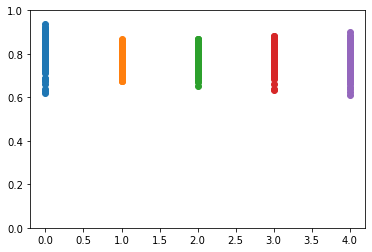

In [27]:
interictal_1 = Segment("Patient_2_interictal_segment_0001.mat", "interictal_segment_1")
ispcs = []
for seg in interictal_1.subsegments:
    ispcs.append(seg.ispc)
ispcs = np.array(ispcs)
plt.figure()
for i in range(5):
    plt.scatter(np.ones(150)*i, ispcs[:, i])
plt.ylim([0, 1])

## Full Patient 1 Classification using ISPC and Band Power

In [19]:
def load_patients(pat_names):
    root = "seizure-prediction"
    i_feats, p_feats = [], []
    for folder in listsubfolders(root):
        if not(folder in pat_names):
            continue
        print(folder)
        datapath = os.path.join(os.path.join(root, folder), folder)
        matfiles = [file for file in os.listdir(datapath) if not("test" in file or ".DS_Store" in file)]
        interictal_seg, preictal_seg = None, None
        for matfile in tqdm(matfiles):
            seg_path = os.path.join(datapath, matfile)
            if "interictal" in matfile:
                seg_name = "interictal_segment_"+str(int(matfile[-8:-4]))
                interictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in interictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                i_feats.append(seg_feats)
            else: #preictal
                seg_name = "preictal_segment_"+str(int(matfile[-8:-4]))
                preictal_seg = Segment(seg_path, seg_name)
                seg_feats = []
                for subseg in preictal_seg.subsegments:
                    seg_feats.append(subseg.feats)
                p_feats.append(seg_feats)
    return i_feats, p_feats
#i_feats, p_feats = load_patients(["Patient_1"])

In [11]:
def loo_xval(i_feats, p_feats):
    loo_accs, i_seg_pred, p_seg_pred = [], [], []
    preictal_thresh = 0.25
    for i in tqdm(range(len(i_feats))):
        p_loo_seg_list = p_feats[i%len(p_feats)]
        p_feat = copy(p_feats)
        p_feat.pop(i%len(p_feats))
        p_feat = sum(p_feat, [])

        i_loo_seg_list = i_feats[i]
        i_feat = copy(i_feats)
        i_feat.pop(i)
        i_feat = sum(i_feat, [])

        #PCA
        pca = PCA()
        ip_feat = i_feat + p_feat
        pca_feat = pca.fit_transform(ip_feat)
        num_i = len(i_feat)
        labels = [0]*num_i + [1]*(len(ip_feat)-num_i)

        #SVM
        svc = SVC()
        svc.fit(pca_feat, labels)
        pred_train = svc.predict(pca_feat)
        zero = np.array(0)
        one = np.array(1)

        #LOO Eval
        loo_ip_feat = i_loo_seg_list + p_loo_seg_list
        loo_labels = [0]*len(i_loo_seg_list) + [1]*len(p_loo_seg_list)
        loo_pca_feats = pca.transform(loo_ip_feat)
        loo_pred = svc.predict(loo_pca_feats)
        loo_accs.append(svc.score(loo_pca_feats, loo_labels))
        if np.sum(loo_pred[:len(i_loo_seg_list)]) / len(i_loo_seg_list) > preictal_thresh:
            i_seg_pred.append(1)
        else:
            i_seg_pred.append(0)
        if i < len(p_feats):
            if np.sum(loo_pred[len(i_loo_seg_list):]) / len(p_loo_seg_list) > preictal_thresh:
                p_seg_pred.append(1)
            else:
                p_seg_pred.append(0)
    return loo_accs, i_seg_pred, p_seg_pred 
loo_accs, i_seg_pred, p_seg_pred = loo_xval(i_feats, p_feats)

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
def print_performance(loo_accs, i_seg_pred, p_seg_pred):
    loo_accs = np.array(loo_accs)
    cross_val_acc = np.mean(loo_accs)
    cross_val_std = np.std(loo_accs)
    print("LOO Cross-Validated Subsegment Accuracy: {} +/- {}".format(cross_val_acc, cross_val_std))
    pred_test = i_seg_pred + p_seg_pred
    y_test = [0]*len(i_seg_pred) + [1]*len(p_seg_pred)
    precision, recall, f_score, _ = prf(y_test, pred_test)
    acc = sum(np.array(pred_test) == np.array(y_test)) / len(y_test)
    print("LOO Cross-Validated Segment accuracy: {}, precision: {}, recall: {}, f_score: {}".format(
        acc, precision, recall, f_score))
print_performance(loo_accs, i_seg_pred, p_seg_pred)

LOO Cross-Validated Subsegment Accuracy: 0.8114 +/- 0.13549266482810876
LOO Cross-Validated Segment accuracy: 0.9705882352941176, precision: [0.98       0.94444444], recall: [0.98       0.94444444], f_score: [0.98       0.94444444]


In [20]:
i_feats, p_feats = load_patients(["Patient_2"])
loo_accs, i_seg_pred, p_seg_pred = loo_xval(i_feats, p_feats)
print_performance(loo_accs, i_seg_pred, p_seg_pred)

Patient_2


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

LOO Cross-Validated Subsegment Accuracy: 0.5016666666666667 +/- 0.0168599898949928
LOO Cross-Validated Segment accuracy: 0.7, precision: [0.7 0. ], recall: [1. 0.], f_score: [0.82352941 0.        ]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
